In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pip install patool

     |████████████████████████████████| 77 kB 3.3 MB/s 


In [ ]:
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/genre_images_v2.rar", outdir="/content")

patool: Extracting /content/drive/MyDrive/genre_images_v2.rar ...
patool: running /usr/bin/unrar x -- /content/drive/MyDrive/genre_images_v2.rar
patool:     with cwd='/content'
patool: ... /content/drive/MyDrive/genre_images_v2.rar extracted to `/content'.


'/content'

In [ ]:

"""
Authors : Rayane KADEM
In This program we use transfer learning with a pretrained vgg16model CNN model. We set the last 4
layers of the convolutional block to be re-trained, and we add 3 fully connected layers for the 
classifciation block. Vgg16 was trained previously on the well known ImageNet dataset. 
The presented architecture is inspired from a work of transfer learning for the task of writer 
identification with handwritten documents and yielded very promessing results. Which led us to test it
on the matter at hand.
"""

# Importing the required libraries
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from fetch_training_dataset import fetch_spectogram_dataset
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
#import argparse
import keras
from keras.layers import Flatten, Dense, Dropout, Conv2D, Activation ,MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping
from fetch_training_dataset import prep_data_images


In [ ]:
data = prep_data_images()
data.prep_data("/content/images",None)

  0%|          | 0/10 [00:00<?, ?it/s]

country



 10%|█         | 1/10 [00:00<00:04,  1.89it/s]

disco



 20%|██        | 2/10 [00:01<00:04,  1.96it/s]

hiphop



 30%|███       | 3/10 [00:01<00:03,  1.96it/s]

blues



 40%|████      | 4/10 [00:02<00:03,  1.96it/s]

classical



 50%|█████     | 5/10 [00:02<00:02,  1.96it/s]

pop



 60%|██████    | 6/10 [00:03<00:02,  1.98it/s]

rock



 70%|███████   | 7/10 [00:03<00:01,  1.95it/s]

reggae



 80%|████████  | 8/10 [00:04<00:01,  1.97it/s]

jazz



 90%|█████████ | 9/10 [00:04<00:00,  1.97it/s]

metal



100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


In [ ]:
width,height,dimenstion = data.Xval[0].shape

# Transfer learning model with rqdm


In [ ]:

# Defining the black box model
class CNNModel:
    def __init__(self):
        self.model = None
        self.model_name = "transfer_learning_vgg16_model_adam_crossEn_orginal_size_val"
        self.model_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + ".h5"
        self.model_weights_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+  self.model_name + "_weights.h5"
        self.model_history_path_acc = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_acc.png"
        self.model_history_path_loss = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_loss.png"
        
        self.model_history = None
    
    def build_model(self):
        """
        This function is used to create the black box model :
        """
        # Defining the input layer
        
        model = Sequential()

        vggmodel=VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(width,height,dimenstion), pooling=None)
        
        # Take all weights of imagenet dataset except for last four layers
        for layer in vggmodel.layers[:-8]: 
            layer.trainable = False 

        x = vggmodel.output
        x = Flatten()(x)

        x = Dense(512, activation="relu")(x)
        x = Dropout(0.2)(x)
        x = Dense(128, activation="elu")(x)
        predictions = Dense(10, activation="softmax")(x)

        # creating the final model 
        model = Model( vggmodel.input, predictions)

        # Compiling the model
        self.model = model
        
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss = "categorical_crossentropy", metrics=['accuracy'])
        return vggmodel, x
    def train_model(self,data, epochs=10):
        """
        This function is used to train the black box model :
        """
        # Training the model
        """
        callback = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.1,
        patience=3,
        min_lr=0.000001
      )"""
        self.model_history = self.model.fit(data.Xtrain,data.ytrain, epochs=epochs,validation_data=(data.Xval,data.yval), shuffle=True)
        
    def save_model(self):
        """
        This function is used to save the black box model :
        """
        # Save the model
        self.model.save(self.model_path)
        
    def load_model(self):
        """
        This function is used to load the black box model :
        """
        # Load the model
        self.model = tf.keras.models.load_model(self.model_path)
        
    def save_model_weights(self):
        """
        This function is used to save the weights of the black box model :
        """
        # Save the weights
        self.model.save_weights(self.model_weights_path)
    

    def evaluate_model(self, Xtest,ytest):
        """
        This function is used to evaluate the black box model :
        """
        # Evaluate the model
        test_loss, test_acc = self.model.evaluate(Xtest,ytest)
        print("Test loss: ", test_loss)
        print("Test accuracy: ", test_acc)
    
    def plot_model_history(self):
        """
        This function is used to plot the model history :
        """
        #define variables
        loss = self.model_history.history['loss']
        val_loss = self.model_history.history['val_loss']
        accuracy = self.model_history.history['accuracy']
        val_accuracy = self.model_history.history['val_accuracy']
        epochs = range(1, len(loss) + 1)
        # Plot the model history
        plt.figure()
        plt.plot(epochs, accuracy, label='Training accuracy')
        plt.plot(epochs, val_accuracy, label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.savefig(self.model_history_path_acc)
        plt.show()

        plt.figure()
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.savefig(self.model_history_path_loss)
        plt.show()
        
    def predict_class(self, spectrogram_image):
        """
        This function is used to predict the class of the spectrogram image :
        """
        # Predict the class
        prediction = self.model.predict(spectrogram_image)
        return np.argmax(prediction)

    def predict_classes(self, spectrogram_images):
        """
        This function is used to predict the classes of the spectrogram images :
        """
        # Predict the classes
        predictions = self.model.predict(spectrogram_images)
        return np.argmax(predictions, axis=1)

    
    def plot_confusion_matrix(self, Xtest,ytest, classes=None):
        """
        This function is used to plot the confusion matrix :
        """
        # Predict the classes
        predictions = self.predict_classes(Xtest)
        # Plot the confusion matrix
        y_parse = np.argmax(ytest, axis=1)
        cm = confusion_matrix(y_parse, predictions)
        #if classes is None:
        #    classes = test_generator.class_indices.keys()
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(10)
        classes = ["rock","hiphop","country","jazz","metal","blues","reggae","disco","Classical","pop"]
        plt.xticks(tick_marks,classes,  rotation=45)
        plt.yticks(tick_marks,classes)
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig("/content/drive/MyDrive/Mymodels_result/"+ self.model_name +"/"+"confusion_matrix.png")
        plt.show()
        acc = np.diag(cm).sum() /cm.sum()
        print("acc",acc)


        



Epoch 1/25
22/22 [==============================] - 15s 621ms/step - loss: 2.2206 - accuracy: 0.2071 - val_loss: 1.9368 - val_accuracy: 0.4000
Epoch 2/25
22/22 [==============================] - 13s 600ms/step - loss: 1.7041 - accuracy: 0.4157 - val_loss: 1.4915 - val_accuracy: 0.5200
Epoch 3/25
22/22 [==============================] - 13s 602ms/step - loss: 1.2238 - accuracy: 0.5914 - val_loss: 1.2504 - val_accuracy: 0.6200
Epoch 4/25
22/22 [==============================] - 13s 604ms/step - loss: 0.9106 - accuracy: 0.6800 - val_loss: 1.0535 - val_accuracy: 0.6500
Epoch 5/25
22/22 [==============================] - 13s 604ms/step - loss: 0.6660 - accuracy: 0.8029 - val_loss: 0.9815 - val_accuracy: 0.6100
Epoch 6/25
22/22 [==============================] - 13s 605ms/step - loss: 0.4806 - accuracy: 0.8600 - val_loss: 0.9106 - val_accuracy: 0.6600
Epoch 7/25
22/22 [==============================] - 13s 607ms/step - loss: 0.3784 - accuracy: 0.8757 - val_loss: 0.9574 - val_accuracy: 0.6800

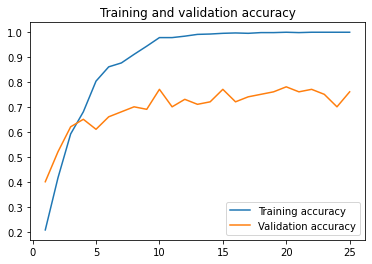

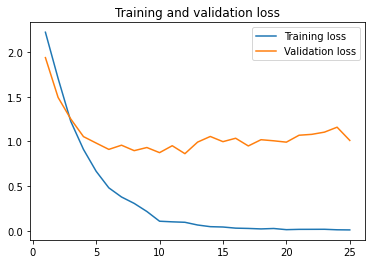

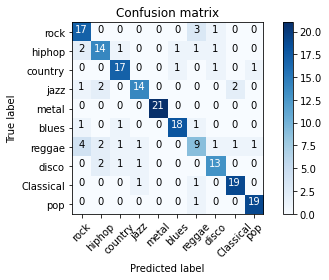

acc 0.805


In [ ]:
for i in range(1):
    
    # Fetch the training and test dataset
    
    # Create the  model
    model = CNNModel()
    
    # Build the  model
    vggmodel, model_features=model.build_model()
    # Train the  model
    model.train_model(data, epochs=25)
    
    # Save the  model
    model.save_model()

    # Evaluate  model
    model.evaluate_model(data.Xtest,data.ytest)

    # Plot the model history
    model.plot_model_history()
    
    # Plot the confusion matrix
    model.plot_confusion_matrix(data.Xtest,data.ytest)


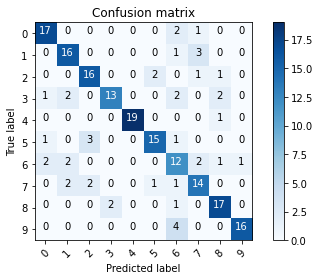

acc 0.775


In [ ]:
model.plot_confusion_matrix(data.Xtest,data.ytest)

## SVM with CNN features

In [ ]:
extractor = Model( vggmodel.input,model_features)

In [ ]:
Xtrain = np.concatenate((data.Xtrain,data.Xval), axis=0)

In [ ]:
xapp = extractor.predict(Xtrain) # training CNN features vector
xtest = extractor.predict(data.Xtest) # testing CNN features vector

In [ ]:
from sklearn import preprocessing 
""" MIN MAX SCALER """
min_max_scaler = preprocessing.MinMaxScaler(feature_range =(0, 1)) 
# Scaled feature 
xapp_n = min_max_scaler.fit_transform(xapp)
xtest_n = min_max_scaler.fit_transform(xtest)

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score

In [ ]:
import pandas as pd
yT  = np.argwhere(np.concatenate((data.ytrain,data.yval),axis=0))
yTr = yT[:,1] 
yT  = np.argwhere(data.ytest)
yTs = yT[:,1] 

In [ ]:

C2 = np.array([100,200,500,1000,2015])
C1 = np.arange(1, 40,2)
C=np.append(C1,C2)
#C = np.append([1],C,axis=0)  #21 values
m=len(C)
G1 = np.array([0.001,0.01,0.1,0.5,1])  #
G2 = np.arange(2, 6, 2)  
G=np.append(G1,G2) 

n=len(G)
#G = G.astype(int)
#tmbr_all = np.zeros((33,11))
i=0
j=0
tmbr_all = np.zeros((n,m))
for C_value in C:
    for g_value in G:
    
        clf = svm.SVC(kernel='rbf', C=C_value, gamma=g_value)
        clf.fit(xapp_n, yTr)
        predicted = clf.predict(xtest_n)
        tmbr = accuracy_score(predicted,yTs)
        print(tmbr*100, C_value, g_value)
        tmbr_all[i,j] = tmbr
        i=i+1
    i=0
    j=j+1
#best_value(tmbr_all,G,C)
accuracy= tmbr_all.max()


33.5 1 0.001
83.5 1 0.01
82.5 1 0.1
76.5 1 0.5
50.5 1 1.0
26.0 1 2.0
14.000000000000002 1 4.0
81.5 3 0.001
83.0 3 0.01
81.5 3 0.1
75.5 3 0.5
53.0 3 1.0
26.0 3 2.0
14.499999999999998 3 4.0
83.0 5 0.001
82.5 5 0.01
81.5 5 0.1
75.5 5 0.5
53.0 5 1.0
26.0 5 2.0
14.499999999999998 5 4.0
83.5 7 0.001
82.0 7 0.01
81.5 7 0.1
75.5 7 0.5
53.0 7 1.0
26.0 7 2.0
14.499999999999998 7 4.0
83.5 9 0.001
83.0 9 0.01
81.5 9 0.1
75.5 9 0.5
53.0 9 1.0
26.0 9 2.0
14.499999999999998 9 4.0
83.0 11 0.001
82.0 11 0.01
81.5 11 0.1
75.5 11 0.5
53.0 11 1.0
26.0 11 2.0
14.499999999999998 11 4.0
83.5 13 0.001
82.0 13 0.01
81.5 13 0.1
75.5 13 0.5
53.0 13 1.0
26.0 13 2.0
14.499999999999998 13 4.0
82.0 15 0.001
82.5 15 0.01
81.5 15 0.1
75.5 15 0.5
53.0 15 1.0
26.0 15 2.0
14.499999999999998 15 4.0
82.5 17 0.001
82.0 17 0.01
81.5 17 0.1
75.5 17 0.5
53.0 17 1.0
26.0 17 2.0
14.499999999999998 17 4.0
82.5 19 0.001
82.0 19 0.01
81.5 19 0.1
75.5 19 0.5
53.0 19 1.0
26.0 19 2.0
14.499999999999998 19 4.0
83.0 21 0.001
82.5 21 0.0

In [ ]:
tmbr_all.max()

0.835

SVM with CNN features did not very much serve our purpose and gave similar values to the fully connected classification block of our CNN model. Thus we might use it again with other features extraction methods. 

# CNN 2 Layers with TQDM

In [ ]:

# Defining the black box model
class CNNModel:
    def __init__(self):
        self.model = None
        self.model_name = "CNN3layers_model_RMSprop_crossEn_orginal_size"
        self.model_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + ".h5"
        self.model_weights_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+  self.model_name + "_weights.h5"
        self.model_history_path_acc = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_acc.png"
        self.model_history_path_loss = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_loss.png"
        
        self.model_history = None
    
    def build_model(self):
        """
        This function is used to create the black box model :
        """
        # Defining the input layer
        
        model = Sequential()

        #Adding the CNN layers along with some drop outs and maxpooling
        model.add(Conv2D(64, (3,3), activation ='relu', input_shape = (width, height, dimenstion)))
        model.add(MaxPooling2D(pool_size = (2,2)))


        model.add(Conv2D(32, (5,5),strides=(1,1) , activation = 'relu'))
        model.add(MaxPooling2D(pool_size = (3,3)))
        
        model.add(Conv2D(32, (3,3),strides=(2,2) , activation = 'relu'))
        model.add(MaxPooling2D(pool_size = (2,2)))

        model.add(Flatten())

        
        #Adding the dense layers
        model.add(Dense(256, activation = 'relu'))
        model.add(Dropout(0.2))
        model.add(Dense(124, activation = 'relu'))
        #final output layer with 10 predictions to be made
        model.add(Dense(10, activation = 'softmax'))
    
        
        
        # Compiling the model
        self.model = model
        model.summary()
        self.model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

        
        
    def train_model(self,data, epochs=10):
        """
        This function is used to train the black box model :
        """
        # Training the model
        """
        callback = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.1,
        patience=3,
        min_lr=0.000001
      )"""
        self.model_history = self.model.fit(data.Xtrain,data.ytrain, epochs=epochs,validation_data=(data.Xval,data.yval), shuffle=True)
        
    def save_model(self):
        """
        This function is used to save the black box model :
        """
        # Save the model
        self.model.save(self.model_path)
        
    def load_model(self):
        """
        This function is used to load the black box model :
        """
        # Load the model
        self.model = tf.keras.models.load_model(self.model_path)
        
    def save_model_weights(self):
        """
        This function is used to save the weights of the black box model :
        """
        # Save the weights
        self.model.save_weights(self.model_weights_path)
    

    def evaluate_model(self, Xtest,ytest):
        """
        This function is used to evaluate the black box model :
        """
        # Evaluate the model
        test_loss, test_acc = self.model.evaluate(Xtest,ytest)
        print("Test loss: ", test_loss)
        print("Test accuracy: ", test_acc)
    
    def plot_model_history(self):
        """
        This function is used to plot the model history :
        """
        #define variables
        loss = self.model_history.history['loss']
        val_loss = self.model_history.history['val_loss']
        accuracy = self.model_history.history['accuracy']
        val_accuracy = self.model_history.history['val_accuracy']
        epochs = range(1, len(loss) + 1)
        # Plot the model history
        plt.figure()
        plt.plot(epochs, accuracy, label='Training accuracy')
        plt.plot(epochs, val_accuracy, label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.savefig(self.model_history_path_acc)
        plt.show()

        plt.figure()
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.savefig(self.model_history_path_loss)
        plt.show()
        
    def predict_class(self, spectrogram_image):
        """
        This function is used to predict the class of the spectrogram image :
        """
        # Predict the class
        prediction = self.model.predict(spectrogram_image)
        return np.argmax(prediction)

    def predict_classes(self, spectrogram_images):
        """
        This function is used to predict the classes of the spectrogram images :
        """
        # Predict the classes
        predictions = self.model.predict(spectrogram_images)
        return np.argmax(predictions, axis=1)

    
    def plot_confusion_matrix(self, Xtest,ytest, classes=None):
        """
        This function is used to plot the confusion matrix :
        """
        # Predict the classes
        predictions = self.predict_classes(Xtest)
        # Plot the confusion matrix
        y_parse = np.argmax(ytest, axis=1)
        cm = confusion_matrix(y_parse, predictions)
        #if classes is None:
        #    classes = test_generator.class_indices.keys()
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(10)
        classes = ["rock","hiphop","country","jazz","metal","blues","reggae","disco","Classical","pop"]
        plt.xticks(tick_marks,classes,  rotation=45)
        plt.yticks(tick_marks,classes)
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig("/content/drive/MyDrive/Mymodels_result/"+ self.model_name +"/"+"confusion_matrix.png")
        plt.show()
        acc = np.diag(cm).sum() /cm.sum()
        print("acc",acc)


        



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 215, 332, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 107, 166, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 103, 162, 32)      51232     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 34, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 26, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 8, 13, 32)       

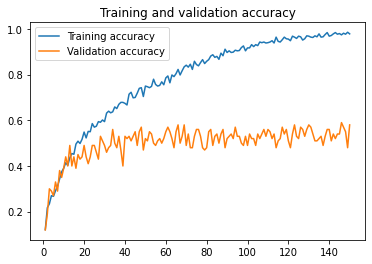

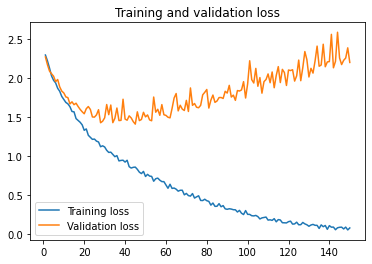

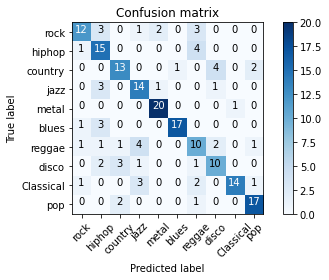

acc 0.71


In [ ]:
for i in range(1):
    
    # Fetch the training and test dataset
    
    # Create the  model
    model = CNNModel()
    
    # Build the  model
    model.build_model()
    # Train the  model
    model.train_model(data, epochs=150)
    
    # Save the  model
    model.save_model()

    # Evaluate  model
    model.evaluate_model(data.Xtest,data.ytest)

    # Plot the model history
    model.plot_model_history()
    
    # Plot the confusion matrix
    model.plot_confusion_matrix(data.Xtest,data.ytest)


#Frequency Model

In [ ]:

# Defining the black box model
class CNNModel:
    def __init__(self):
        self.model = None
        self.model_name = "frequency_model_Adam_crossEn_orginal_size_default_lr"
        self.model_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + ".h5"
        self.model_weights_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+  self.model_name + "_weights.h5"
        self.model_history_path_acc = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_acc.png"
        self.model_history_path_loss = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_loss.png"
        
        self.model_history = None
    
    def build_model(self):
        """
        This function is used to create the black box model :
        """
        # Defining the input layer
        
        model = Sequential()

        #Adding the CNN layers along with some drop outs and maxpooling
        model.add(Conv2D(32, (4,1), activation ='relu', input_shape = (width, height, dimenstion)))
        model.add(MaxPooling2D(pool_size = (1,height)))
        model.add(Flatten())
        model.add(Dense(10, activation = 'softmax'))
    
        
        
        # Compiling the model
        self.model = model
        model.summary()
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
        return 
        
        
    def train_model(self,data, epochs=10):
        """
        This function is used to train the black box model :
        """
        # Training the model
        """
        callback = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.1,
        patience=3,
        min_lr=0.000001
      )"""
        self.model_history = self.model.fit(data.Xtrain,data.ytrain, epochs=epochs,validation_data=(data.Xval,data.yval), shuffle=True)
        
    def save_model(self):
        """
        This function is used to save the black box model :
        """
        # Save the model
        self.model.save(self.model_path)
        
    def load_model(self):
        """
        This function is used to load the black box model :
        """
        # Load the model
        self.model = tf.keras.models.load_model(self.model_path)
        
    def save_model_weights(self):
        """
        This function is used to save the weights of the black box model :
        """
        # Save the weights
        self.model.save_weights(self.model_weights_path)
    

    def evaluate_model(self, Xtest,ytest):
        """
        This function is used to evaluate the black box model :
        """
        # Evaluate the model
        test_loss, test_acc = self.model.evaluate(Xtest,ytest)
        print("Test loss: ", test_loss)
        print("Test accuracy: ", test_acc)
    
    def plot_model_history(self):
        """
        This function is used to plot the model history :
        """
        #define variables
        loss = self.model_history.history['loss']
        val_loss = self.model_history.history['val_loss']
        accuracy = self.model_history.history['accuracy']
        val_accuracy = self.model_history.history['val_accuracy']
        epochs = range(1, len(loss) + 1)
        # Plot the model history
        plt.figure()
        plt.plot(epochs, accuracy, label='Training accuracy')
        plt.plot(epochs, val_accuracy, label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.savefig(self.model_history_path_acc)
        plt.show()

        plt.figure()
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.savefig(self.model_history_path_loss)
        plt.show()
        
    def predict_class(self, spectrogram_image):
        """
        This function is used to predict the class of the spectrogram image :
        """
        # Predict the class
        prediction = self.model.predict(spectrogram_image)
        return np.argmax(prediction)

    def predict_classes(self, spectrogram_images):
        """
        This function is used to predict the classes of the spectrogram images :
        """
        # Predict the classes
        predictions = self.model.predict(spectrogram_images)
        return np.argmax(predictions, axis=1)

    
    def plot_confusion_matrix(self, Xtest,ytest, classes=None):
        """
        This function is used to plot the confusion matrix :
        """
        # Predict the classes
        predictions = self.predict_classes(Xtest)
        # Plot the confusion matrix
        y_parse = np.argmax(ytest, axis=1)
        cm = confusion_matrix(y_parse, predictions)
        #if classes is None:
        #    classes = test_generator.class_indices.keys()
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(10)
        classes = ["rock","hiphop","country","jazz","metal","blues","reggae","disco","Classical","pop"]
        plt.xticks(tick_marks,classes,  rotation=45)
        plt.yticks(tick_marks,classes)
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig("/content/drive/MyDrive/Mymodels_result/"+ self.model_name +"/"+"confusion_matrix.png")
        plt.show()
        acc = np.diag(cm).sum() /cm.sum()
        print("acc",acc)


        



Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 214, 334, 32)      416       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 214, 1, 32)       0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 6848)              0         
                                                                 
 dense_23 (Dense)            (None, 10)                68490     
                                                                 
Total params: 68,906
Trainable params: 68,906
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
22/22 [==============================] - 3s 106ms/step - loss: 2.3112 - accuracy: 0.1571 - val_loss: 2.

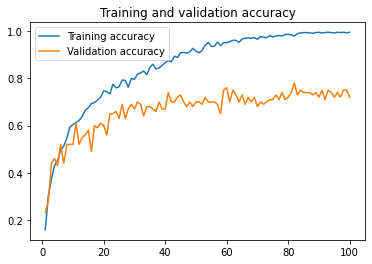

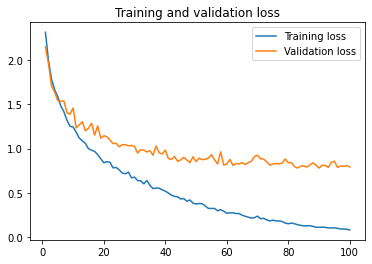

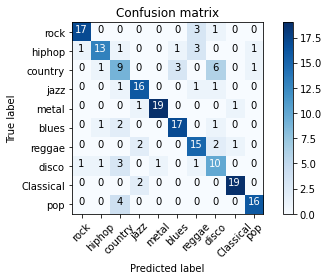

acc 0.755


In [ ]:
for i in range(1):
    
    # Fetch the training and test dataset
    
    # Create the  model
    model = CNNModel()
    
    # Build the  model
    model.build_model()
    # Train the  model
    model.train_model(data, epochs=100)
    
    # Save the  model
    model.save_model()

    # Evaluate  model
    model.evaluate_model(data.Xtest,data.ytest)

    # Plot the model history
    model.plot_model_history()
    
    # Plot the confusion matrix
    model.plot_confusion_matrix(data.Xtest,data.ytest)


In [ ]:
x= model.model.layers[-2].output
freq_model = Model(model.model.input,x)
Xtest_freq = freq_model.predict(data.Xtest)
Xtrain_freq = freq_model.predict(data.Xtrain)
Xval_freq = freq_model.predict(data.Xval)

# Time Model

In [ ]:
width, height, dimenstion


(217, 334, 3)

In [ ]:
# Defining the black box model
class CNNModel:
    def __init__(self):
        self.model = None
        self.model_name = "time_model2_Adam_crossEn_orginal_size_default_lr"
        self.model_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + ".h5"
        self.model_weights_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+  self.model_name + "_weights.h5"
        self.model_history_path_acc = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_acc.png"
        self.model_history_path_loss = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_loss.png"
        
        self.model_history = None
    
    def build_model(self):
        """
        This function is used to create the black box model :
        """
        # Defining the input layer
        
        model = Sequential()

        #Adding the CNN layers along with some drop outs and maxpooling
        model.add(Conv2D(32, (1,4), activation ='relu', input_shape = (width, height, dimenstion)))
        model.add(MaxPooling2D(pool_size = (width,1)))
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(10, activation = 'softmax'))
    
        
        
        # Compiling the model
        self.model = model
        model.summary()
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
        
        
        
    def train_model(self,data, epochs=10):
        """
        This function is used to train the black box model :
        """
        # Training the model
        """
        callback = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.1,
        patience=3,
        min_lr=0.000001
      )"""
        self.model_history = self.model.fit(data.Xtrain,data.ytrain, epochs=epochs,validation_data=(data.Xval,data.yval), shuffle=True)
        
    def save_model(self):
        """
        This function is used to save the black box model :
        """
        # Save the model
        self.model.save(self.model_path)
        
    def load_model(self):
        """
        This function is used to load the black box model :
        """
        # Load the model
        self.model = tf.keras.models.load_model(self.model_path)
        
    def save_model_weights(self):
        """
        This function is used to save the weights of the black box model :
        """
        # Save the weights
        self.model.save_weights(self.model_weights_path)
    

    def evaluate_model(self, Xtest,ytest):
        """
        This function is used to evaluate the black box model :
        """
        # Evaluate the model
        test_loss, test_acc = self.model.evaluate(Xtest,ytest)
        print("Test loss: ", test_loss)
        print("Test accuracy: ", test_acc)
    
    def plot_model_history(self):
        """
        This function is used to plot the model history :
        """
        #define variables
        loss = self.model_history.history['loss']
        val_loss = self.model_history.history['val_loss']
        accuracy = self.model_history.history['accuracy']
        val_accuracy = self.model_history.history['val_accuracy']
        epochs = range(1, len(loss) + 1)
        # Plot the model history
        plt.figure()
        plt.plot(epochs, accuracy, label='Training accuracy')
        plt.plot(epochs, val_accuracy, label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.savefig(self.model_history_path_acc)
        plt.show()

        plt.figure()
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.savefig(self.model_history_path_loss)
        plt.show()
        
    def predict_class(self, spectrogram_image):
        """
        This function is used to predict the class of the spectrogram image :
        """
        # Predict the class
        prediction = self.model.predict(spectrogram_image)
        return np.argmax(prediction)

    def predict_classes(self, spectrogram_images):
        """
        This function is used to predict the classes of the spectrogram images :
        """
        # Predict the classes
        predictions = self.model.predict(spectrogram_images)
        return np.argmax(predictions, axis=1)

    
    def plot_confusion_matrix(self, Xtest,ytest, classes=None):
        """
        This function is used to plot the confusion matrix :
        """
        # Predict the classes
        predictions = self.predict_classes(Xtest)
        # Plot the confusion matrix
        y_parse = np.argmax(ytest, axis=1)
        cm = confusion_matrix(y_parse, predictions)
        #if classes is None:
        #    classes = test_generator.class_indices.keys()
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(10)
        classes = ["rock","hiphop","country","jazz","metal","blues","reggae","disco","Classical","pop"]
        plt.xticks(tick_marks,classes,  rotation=45)
        plt.yticks(tick_marks,classes)
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig("/content/drive/MyDrive/Mymodels_result/"+ self.model_name +"/"+"confusion_matrix.png")
        plt.show()
        acc = np.diag(cm).sum() /cm.sum()
        print("acc",acc)


        



In [ ]:
for i in range(1):
    
    # Fetch the training and test dataset
    
    # Create the  model
    model = CNNModel()
    
    # Build the  model
    model.build_model()
    # Train the  model
    model.train_model(data, epochs=200)
    
    # Save the  model
    model.save_model()

    # Evaluate  model
    model.evaluate_model(data.Xtest,data.ytest)

    # Plot the model history
    model.plot_model_history()
    
    # Plot the confusion matrix
    model.plot_confusion_matrix(data.Xtest,data.ytest)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 217, 327, 32)      800       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 1, 327, 32)       0         
 g2D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 10464)             0         
                                                                 
 dropout_8 (Dropout)         (None, 10464)             0         
                                                                 
 dense_37 (Dense)            (None, 10)                104650    
                                                                 
Total params: 105,450
Trainable params: 105,450
Non-trainable params: 0
_______________________________________________

KeyboardInterrupt: ignored

In [ ]:
x= model.model.layers[-2].output
time_model = Model(model.model.input,x)
Xtest_time = time_model.predict(data.Xtest)
Xtrain_time = time_model.predict(data.Xtrain)
Xval_time = time_model.predict(data.Xval)

In [ ]:
Xtrain_time.mean()

0.20555413

# Hybrid Model freq/time

In [ ]:
Xtrain_freq.shape

(700, 6848)

## Dimension reduction using PCA

In [ ]:
from sklearn.decomposition import PCA
# Reduce dimensionality with PCA

# For time 
pca = PCA(n_components=300)
pca.fit(Xtrain_time)
XtrainT_time = pca.transform(Xtrain_time)
XtestT_time = pca.transform(Xtest_time)
XvalT_time = pca.transform(Xval_time)


In [ ]:
# For frequency
pca = PCA(n_components=500)
pca.fit(Xtrain_freq)
XtrainT_freq = pca.transform(Xtrain_freq)
XtestT_freq = pca.transform(Xtest_freq)
XvalT_freq = pca.transform(Xval_freq)

## mix two features vectors

In [ ]:
XtestT_time.shape

(200, 2648)

In [ ]:
XtestT_freq = Xtest_freq[:,0::2]
XtrainT_freq = Xtrain_freq[:,0::2]
XvalT_freq = Xval_freq[:,0::2]

In [ ]:
XtestT_time= Xtest_time[:,0::3]
XtrainT_time = Xtrain_time[:,0::3]
XvalT_time = Xval_time[:,0::3]

In [ ]:
Xtest_hybrid = np.concatenate((XtestT_freq,XtestT_time),axis=1)
Xtrain_hybrid = np.concatenate((XtrainT_freq,XtrainT_time),axis=1)
Xval_hybrid = np.concatenate((XvalT_freq,XvalT_time),axis=1)


In [ ]:
Xtest_hybrid.max()

1.0000019

In [ ]:
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
""" MIN MAX SCALER """
min_max_scaler = preprocessing.MinMaxScaler(feature_range =(0, 1)) 
#min_max_scaler= StandardScaler()
# Scaled feature 
Xtest_hybrid = min_max_scaler.fit_transform(Xtest_hybrid)
Xtrain_hybrid = min_max_scaler.fit_transform(Xtrain_hybrid)
Xval_hybrid = min_max_scaler.fit_transform(Xval_hybrid)

In [ ]:
length = Xtest_hybrid.shape[1]

In [ ]:
length

6955

In [ ]:
# Defining the black box model
class CNNModel:
    def __init__(self):
        self.model = None
        self.model_name = "Hybrid_Adam_crossEn_orginal_size"
        self.model_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + ".h5"
        self.model_weights_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+  self.model_name + "_weights.h5"
        self.model_history_path_acc = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_acc.png"
        self.model_history_path_loss = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_loss.png"
        
        self.model_history = None
    
    def build_model(self):
        """
        This function is used to create the black box model :
        """
        # Defining the input layer
        
        model = Sequential()
        model.add(Dense(256, input_shape=(length,)))
        model.add(Dropout(0.3))
        #Adding the dense layers
        model.add(Dense(124, activation = 'relu'))
        model.add(Dropout(0.1))
        model.add(Dense(64, activation = 'relu'))
        #final output layer with 10 predictions to be made
        model.add(Dense(10, activation = 'softmax'))

        
        
        # Compiling the model
        self.model = model
        model.summary()
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000005), loss='categorical_crossentropy', metrics=['accuracy'])
        
        
        
    def train_model(self,Xtrain,ytrain,Xval,yval, epochs=10):
        """
        This function is used to train the black box model :
        """
        # Training the model
        """
        callback = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.1,
        patience=3,
        min_lr=0.000001
      )"""
        self.model_history = self.model.fit(Xtrain,ytrain, epochs=epochs,validation_data=(Xval,yval), shuffle=True)
        
    def save_model(self):
        """
        This function is used to save the black box model :
        """
        # Save the model
        self.model.save(self.model_path)
        
    def load_model(self):
        """
        This function is used to load the black box model :
        """
        # Load the model
        self.model = tf.keras.models.load_model(self.model_path)
        
    def save_model_weights(self):
        """
        This function is used to save the weights of the black box model :
        """
        # Save the weights
        self.model.save_weights(self.model_weights_path)
    

    def evaluate_model(self, Xtest,ytest):
        """
        This function is used to evaluate the black box model :
        """
        # Evaluate the model
        test_loss, test_acc = self.model.evaluate(Xtest,ytest)
        print("Test loss: ", test_loss)
        print("Test accuracy: ", test_acc)
    
    def plot_model_history(self):
        """
        This function is used to plot the model history :
        """
        #define variables
        loss = self.model_history.history['loss']
        val_loss = self.model_history.history['val_loss']
        accuracy = self.model_history.history['accuracy']
        val_accuracy = self.model_history.history['val_accuracy']
        epochs = range(1, len(loss) + 1)
        # Plot the model history
        plt.figure()
        plt.plot(epochs, accuracy, label='Training accuracy')
        plt.plot(epochs, val_accuracy, label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.savefig(self.model_history_path_acc)
        plt.show()

        plt.figure()
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.savefig(self.model_history_path_loss)
        plt.show()
        
    def predict_class(self, spectrogram_image):
        """
        This function is used to predict the class of the spectrogram image :
        """
        # Predict the class
        prediction = self.model.predict(spectrogram_image)
        return np.argmax(prediction)

    def predict_classes(self, spectrogram_images):
        """
        This function is used to predict the classes of the spectrogram images :
        """
        # Predict the classes
        predictions = self.model.predict(spectrogram_images)
        return np.argmax(predictions, axis=1)

    
    def plot_confusion_matrix(self, Xtest,ytest, classes=None):
        """
        This function is used to plot the confusion matrix :
        """
        # Predict the classes
        predictions = self.predict_classes(Xtest)
        # Plot the confusion matrix
        y_parse = np.argmax(ytest, axis=1)
        cm = confusion_matrix(y_parse, predictions)
        #if classes is None:
        #    classes = test_generator.class_indices.keys()
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(10)
        classes = ["rock","hiphop","country","jazz","metal","blues","reggae","disco","Classical","pop"]
        plt.xticks(tick_marks,classes,  rotation=45)
        plt.yticks(tick_marks,classes)
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig("/content/drive/MyDrive/Mymodels_result/"+ self.model_name +"/"+"confusion_matrix.png")
        plt.show()
        acc = np.diag(cm).sum() /cm.sum()
        print("acc",acc)


        



Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 256)               1780736   
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                                 
 dense_78 (Dense)            (None, 124)               31868     
                                                                 
 dropout_25 (Dropout)        (None, 124)               0         
                                                                 
 dense_79 (Dense)            (None, 64)                8000      
                                                                 
 dense_80 (Dense)            (None, 10)                650       
                                                                 
Total params: 1,821,254
Trainable params: 1,821,254
N

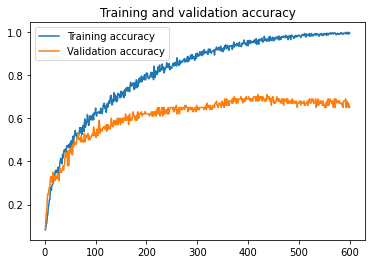

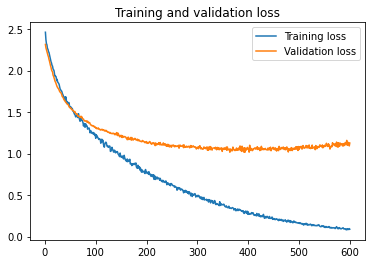

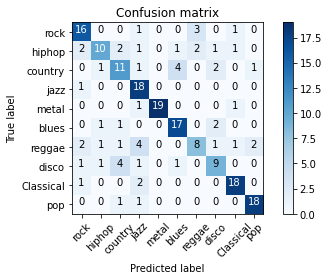

acc 0.72


In [ ]:
for i in range(1):
    
    # Fetch the training and test dataset
    
    # Create the  model
    model = CNNModel()
    
    # Build the  model
    model.build_model()
    # Train the  model
    model.train_model(Xtrain_hybrid,data.ytrain,Xval_hybrid,data.yval, epochs=600)
    
    # Save the  model
    model.save_model()

    # Evaluate  model
    model.evaluate_model(Xtest_hybrid,data.ytest)

    # Plot the model history
    model.plot_model_history()
    
    # Plot the confusion matrix
    model.plot_confusion_matrix(Xtest_hybrid,data.ytest)

# GEN mode CNN Model


In [ ]:
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/MLspectrogram.rar", outdir="/content")

patool: Extracting /content/drive/MyDrive/MLspectrogram.rar ...
patool: running /usr/bin/unrar x -- /content/drive/MyDrive/MLspectrogram.rar
patool:     with cwd='/content'
patool: ... /content/drive/MyDrive/MLspectrogram.rar extracted to `/content'.


'/content'

In [ ]:
  
"""
Authors : Rayane KADEM
This programm is used to create a class that represents a black box model using tensorflox framework. :
    - The model conssists of  CNN layer, Fully connected layers and a softmax layer :
    - The CNN is used to extract features from spectrogram images and it contains :
        - 
        -
    - The output of CNN is flattened and fed into a fully connected layer with .. neurons
    - The output of fully connected layer is fed into a softmax layer with 10 neurons
"""

# Importing the required libraries
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from fetch_training_dataset2 import fetch_spectogram_dataset
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
#import argparse
import keras
from keras.layers import Flatten, Dense, Dropout, Conv2D, Activation ,MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential
from keras.layers import LeakyReLU

# Defining the black box model
class CNNModel:
    def __init__(self):
        self.model = None
        self.model_name = "2layers_CNN_model_mlSpectrogram"
        self.model_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + ".h5"
        self.model_weights_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+  self.model_name + "_weights.h5"
        self.model_history_path_acc = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_acc.png"
        self.model_history_path_loss = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_loss.png"
        
        self.model_history = None
    
    def build_model(self):
        """
        This function is used to create the black box model :
        """
        # Defining the input layer
        
        model = Sequential()

        #Adding the CNN layers along with some drop outs and maxpooling
        model.add(Conv2D(64, (3,3), activation ='relu', input_shape = (217, 334, 3)))
        model.add(MaxPooling2D(pool_size = (2,2)))


        model.add(Conv2D(32, (3,3),strides=(1,1) , activation = 'relu'))
        model.add(MaxPooling2D(pool_size = (2,2)))
        
        model.add(Flatten())

        
        #Adding the dense layers
        model.add(Dense(256, activation = 'relu'))
        model.add(Dropout(0.5))
        model.add(Dense(124, activation = 'relu'))
        #final output layer with 10 predictions to be made
        model.add(Dense(10, activation = 'softmax'))
    
        
        
        # Compiling the model
        self.model = model
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

        
    def train_model(self, train_generator,validation_generator, epochs=10):
        """
        This function is used to train the black box model :
        """
        # Training the model
        self.model_history = self.model.fit(train_generator, epochs=epochs,validation_data=validation_generator, shuffle=True)

        
    def save_model(self):
        """
        This function is used to save the black box model :
        """
        # Save the model
        self.model.save(self.model_path)
        
    def load_model(self):
        """
        This function is used to load the black box model :
        """
        # Load the model
        self.model = tf.keras.models.load_model(self.model_path)
        
    def save_model_weights(self):
        """
        This function is used to save the weights of the black box model :
        """
        # Save the weights
        self.model.save_weights(self.model_weights_path)
    

    def evaluate_model(self, test_generator):
        """
        This function is used to evaluate the black box model :
        """
        # Evaluate the model
        test_loss, test_acc = self.model.evaluate(test_generator)
        print("Test loss: ", test_loss)
        print("Test accuracy: ", test_acc)
    
    def plot_model_history(self):
        """
        This function is used to plot the model history :
        """
        #define variables
        loss = self.model_history.history['loss']
        val_loss = self.model_history.history['val_loss']
        accuracy = self.model_history.history['accuracy']
        val_accuracy = self.model_history.history['val_accuracy']
        epochs = range(1, len(loss) + 1)
        # Plot the model history
        plt.figure()
        plt.plot(epochs, accuracy, label='Training accuracy')
        plt.plot(epochs, val_accuracy, label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.savefig(self.model_history_path_acc)
        plt.show()

        plt.figure()
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.savefig(self.model_history_path_loss)
        plt.show()
        

    def predict_classes(self, spectrogram_images):
        """
        This function is used to predict the classes of the spectrogram images :
        """
        # Predict the classes
        predictions = self.model.predict(spectrogram_images)
        return np.argmax(predictions, axis=1)

    
    def plot_confusion_matrix(self, test_generator, classes=None):
        """
        This function is used to plot the confusion matrix :
        """
        # Predict the classes
        predictions = self.predict_classes(test_generator)
        # Plot the confusion matrix
        cm = confusion_matrix(test_generator.classes, predictions)
        if classes is None:
            classes = test_generator.class_indices.keys()
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig("/content/drive/MyDrive/Mymodels_result/"+ self.model_name +"/"+"confusion_matrix.png")
        plt.show()
        acc = np.diag(cm).sum() /cm.sum()
        print("acc",acc)

def main():
    
    # Fetch the training and test dataset
    train_generator = fetch_spectogram_dataset("data/train")
    test_generator =  fetch_spectogram_dataset("data/test")
    validation_generator =  fetch_spectogram_dataset("data/validation")
    # Create the black box model
    model = CNNModel()
    
    # Build the black box model
    model.build_model()
    
    # Train the black box model
    model.train_model(train_generator,validation_generator, epochs=200)

    # Save the black box model
    model.save_model()

    # Evaluate the black box model
    model.evaluate_model(test_generator)

    # Plot the model history
    model.plot_model_history()
    
    # Plot the confusion matrix
    model.plot_confusion_matrix(test_generator)

if __name__ == "__main__":
    main()


Found 700 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/200
70/70 [==============================] - 6s 77ms/step - loss: 2.3796 - accuracy: 0.0643 - val_loss: 2.2993 - val_accuracy: 0.1000
Epoch 2/200
70/70 [==============================] - 5s 73ms/step - loss: 2.3138 - accuracy: 0.1100 - val_loss: 2.2959 - val_accuracy: 0.1000
Epoch 3/200
70/70 [==============================] - 5s 73ms/step - loss: 2.3013 - accuracy: 0.1200 - val_loss: 2.2832 - val_accuracy: 0.2000
Epoch 4/200
70/70 [==============================] - 5s 74ms/step - loss: 2.3017 - accuracy: 0.1043 - val_loss: 2.2748 - val_accuracy: 0.1400
Epoch 5/200
70/70 [==============================] - 5s 73ms/step - loss: 2.2867 - accuracy: 0.1300 - val_loss: 2.2653 - val_accuracy: 0.2400
Epoch 6/200
70/70 [==============================] - 5s 74ms/step - loss: 2.2706 - accuracy: 0.1186 - val_loss: 2.2506 - val_accuracy: 0.1500
Epoch 7/200
70/70 [==============================] - 5s 75ms/step - loss: 2.2764 - accuracy: 0.1171 - val_loss: 2.2346 - val_accuracy: 0.2800
Epoch 

KeyboardInterrupt: ignored